In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
from torchvision import datasets, models
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils import spectral_norm


from torch.utils.tensorboard import SummaryWriter  

from tqdm import tqdm
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from config import get_weights_file_path

In [59]:
BATCH_SIZE = 32
LR = 1e-4
LATENT_DIM = 512
IMAGE_DIM = 64 * 64 * 3
NUM_EPOCHS = 50
WEIGHT_PATH = "weights/lsun"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")  # Force CPU for debugging

In [ ]:
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
from PIL import Image

class LSUNDataset(Dataset):
    def __init__(self, dataset,
                batch_size: int = 32,
                transform = None,
                im_size: int = 64):
        self.ds = dataset
        self.batch_size = batch_size
        
        # Default transforms
        self.transform = transform or transforms.Compose([
            transforms.Resize((im_size, im_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def __len__(self) -> int:
        return len(self.ds)

    def __getitem__(self, idx: int):
        img = self.ds[idx]['pixel_values']
        return self.transform(img)

    def get_dataloader(self, shuffle: bool = True) -> DataLoader:
        return DataLoader(self, batch_size=self.batch_size, shuffle=shuffle)

In [ ]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
ds_train = load_dataset("nzm97/lsun_bedroom_64x64", split = 'train')

In [ ]:
ds_train = load_dataset("nzm97/lsun_bedroom_64x64", split = 'train')
train_dataset = LSUNDataset(
    dataset = ds_train,
    batch_size = BATCH_SIZE,
    im_size = 64
)

train_dataloader = train_dataset.get_dataloader()

In [63]:
# print shape of a single batch
for batch in train_dataloader:
    print(batch.shape)
    break

torch.Size([32, 3, 64, 64])


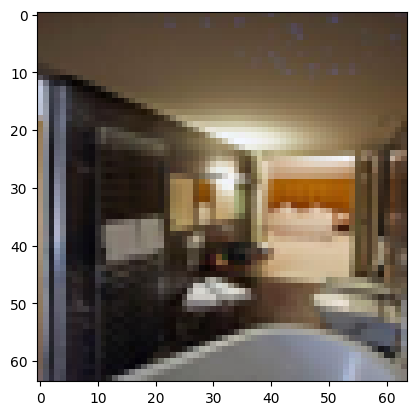

In [112]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    # Denormalize from [-1,1] to [0,1]
    img = img / 2 + 0.5  # Equivalent to (img + 1) / 2
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Usage example:
for images in train_dataloader:
    imshow(images[4])  # Show first image in batch
    break

In [65]:
class Generator(nn.Module):
    '''
    Generates 64x64 RGB images from random noise
    in: latent_dim
    out: 3x64x64
    '''
    def __init__(self, z_dim):
        super().__init__()
        self.gen = nn.Sequential(
            # Initial dense layer
            nn.Linear(z_dim, 4*4*512),
            nn.BatchNorm1d(4*4*512),
            nn.ReLU(True),
            
            # Reshape and start transposed convolutions
            nn.Unflatten(1, (512, 4, 4)),
            
            # Block 1: 4x4 -> 8x8
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            # Block 2: 8x8 -> 16x16
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            # Block 3: 16x16 -> 32x32
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            # Block 4: 32x32 -> 64x64
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
        )
        
        # Final convolution to get to 3 channels
        self.final_conv = nn.Conv2d(32, 3, kernel_size=3, padding=1)
        self.tanh = nn.Tanh()
    
    def forward(self, x):
        x = self.gen(x)
        x = self.final_conv(x)
        return self.tanh(x)
    
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        
        self.model = nn.Sequential(
            # Input: 3x64x64
            spectral_norm(nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 64x32x32
            spectral_norm(nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 128x16x16
            spectral_norm(nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 256x8x8
            spectral_norm(nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 512x4x4
            nn.Flatten(),
            spectral_norm(nn.Linear(512*4*4, 1))
        )
    
    def forward(self, x):
        return self.model(x)

In [67]:
# training loop
disc = Discriminator().to(device)
gen = Generator(LATENT_DIM).to(device)

os.makedirs(WEIGHT_PATH, exist_ok=True)
os.makedirs(os.path.join(WEIGHT_PATH, "generator"), exist_ok=True)

opt_disc = optim.Adam(disc.parameters(), lr = LR)
opt_gen = optim.Adam(gen.parameters(), lr = LR)
fixed_noise = torch.randn((BATCH_SIZE, LATENT_DIM)).to(device)

criterion = nn.BCEWithLogitsLoss()

writer_fake = SummaryWriter("lsun_logs/fake")
writer_real = SummaryWriter("lsun_logs/real")
step = 0

for epoch in range(NUM_EPOCHS):
        for batch_idx, (real) in enumerate(tqdm(train_dataloader)):
            # real is a batched tensor of the shape (batch_size, *img_dims) *img_dims = 1, 28, 28 for MNIST
            real = real.to(device)
            batch_size = real.shape[0]

            ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
            ## The Discriminator must always be trained first to provide meaningful gradients for the generator
            noise = torch.randn(BATCH_SIZE, LATENT_DIM).to(device)
            fake = gen(noise)
            disc_real = disc(real).view(-1)
            # torch.ones_like function creates a tensor of the same shape as the input tensor filled with ones
            lossD_real = criterion(disc_real, torch.ones_like(disc_real))
            disc_fake = disc(fake).view(-1)
            lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
            lossD = (lossD_real + lossD_fake) / 2
            disc.zero_grad()
            lossD.backward(retain_graph=True)
            opt_disc.step()

            ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
            ## Here only the fake samples are passed to the discriminator as only those matter in measuring the quality of the generator
            output = disc(fake).view(-1)
            lossG = criterion(output, torch.ones_like(output))
            gen.zero_grad() # clears old gradients
            lossG.backward() # computes new gradients
            opt_gen.step() # updates weights based on gradients

            if batch_idx == 0:
                
                print(
                    f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(train_dataloader)} \
                        Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
                )

                with torch.no_grad():
                    fake = gen(fixed_noise)
                    data = real
                    img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
                    img_grid_real = torchvision.utils.make_grid(data, normalize=True)

                    writer_fake.add_image(
                        "LSUN Fake Images", img_grid_fake, global_step=step
                    )
                    writer_real.add_image(
                        "LSUN Real Images", img_grid_real, global_step=step
                    )
                    step += 1

        # # save model weights every 10 epochs with epoch as suffix

        torch.save(gen.state_dict(), os.path.join(WEIGHT_PATH, f"{epoch+1:02d}"))

  0%|          | 0/8999 [00:00<?, ?it/s]

Epoch [0/50] Batch 0/8999                         Loss D: 0.7139, loss G: 0.6600


  0%|          | 1/8999 [00:00<43:32,  3.44it/s]

Epoch [1/50] Batch 0/8999                         Loss D: 0.6341, loss G: 1.6115


  0%|          | 0/8999 [00:00<?, ?it/s]

Epoch [2/50] Batch 0/8999                         Loss D: 0.5341, loss G: 1.0645


  0%|          | 0/8999 [00:00<?, ?it/s]

Epoch [3/50] Batch 0/8999                         Loss D: 0.5149, loss G: 1.3245


  0%|          | 1/8999 [00:00<43:12,  3.47it/s]

Epoch [4/50] Batch 0/8999                         Loss D: 0.3576, loss G: 1.8045


  0%|          | 1/8999 [00:00<43:44,  3.43it/s]

Epoch [5/50] Batch 0/8999                         Loss D: 0.3896, loss G: 1.4966


  0%|          | 1/8999 [00:00<46:53,  3.20it/s]

Epoch [6/50] Batch 0/8999                         Loss D: 0.4056, loss G: 1.2183


  0%|          | 1/8999 [00:00<47:13,  3.18it/s]

Epoch [7/50] Batch 0/8999                         Loss D: 0.5024, loss G: 1.0622


  0%|          | 1/8999 [00:00<41:37,  3.60it/s]

Epoch [8/50] Batch 0/8999                         Loss D: 0.4626, loss G: 1.5229


  0%|          | 1/8999 [00:00<48:01,  3.12it/s]

Epoch [9/50] Batch 0/8999                         Loss D: 0.4879, loss G: 1.1549


  0%|          | 1/8999 [00:00<45:08,  3.32it/s]

Epoch [10/50] Batch 0/8999                         Loss D: 0.3314, loss G: 1.4752


  0%|          | 0/8999 [00:00<?, ?it/s]

Epoch [11/50] Batch 0/8999                         Loss D: 0.3731, loss G: 1.2519


  0%|          | 1/8999 [00:00<43:45,  3.43it/s]

Epoch [12/50] Batch 0/8999                         Loss D: 0.3818, loss G: 1.5989


  0%|          | 1/8999 [00:00<53:48,  2.79it/s]

Epoch [13/50] Batch 0/8999                         Loss D: 0.5322, loss G: 1.0138


  0%|          | 1/8999 [00:00<43:55,  3.41it/s]

Epoch [14/50] Batch 0/8999                         Loss D: 0.5659, loss G: 1.3040


  0%|          | 1/8999 [00:00<48:20,  3.10it/s]

Epoch [15/50] Batch 0/8999                         Loss D: 0.4282, loss G: 1.1418


  0%|          | 0/8999 [00:00<?, ?it/s]

Epoch [16/50] Batch 0/8999                         Loss D: 0.5655, loss G: 0.8312


  0%|          | 1/8999 [00:00<44:48,  3.35it/s]

Epoch [17/50] Batch 0/8999                         Loss D: 0.5376, loss G: 0.9921


  0%|          | 0/8999 [00:00<?, ?it/s]

Epoch [18/50] Batch 0/8999                         Loss D: 0.5920, loss G: 1.0724


  0%|          | 1/8999 [00:00<47:29,  3.16it/s]

Epoch [19/50] Batch 0/8999                         Loss D: 0.5333, loss G: 1.0588


  0%|          | 1/8999 [00:00<45:24,  3.30it/s]

Epoch [20/50] Batch 0/8999                         Loss D: 0.5009, loss G: 1.1655


  0%|          | 0/8999 [00:00<?, ?it/s]

Epoch [21/50] Batch 0/8999                         Loss D: 0.5583, loss G: 0.9799


  0%|          | 0/8999 [00:00<?, ?it/s]

Epoch [22/50] Batch 0/8999                         Loss D: 0.6030, loss G: 0.7960


  0%|          | 1/8999 [00:00<43:09,  3.47it/s]

Epoch [23/50] Batch 0/8999                         Loss D: 0.5776, loss G: 0.7906


  0%|          | 1/8999 [00:00<45:06,  3.33it/s]

Epoch [24/50] Batch 0/8999                         Loss D: 0.5551, loss G: 0.9868


  0%|          | 0/8999 [00:00<?, ?it/s]

Epoch [25/50] Batch 0/8999                         Loss D: 0.5752, loss G: 0.9202


  0%|          | 1/8999 [00:00<43:40,  3.43it/s]

Epoch [26/50] Batch 0/8999                         Loss D: 0.6293, loss G: 0.7633


  0%|          | 1/8999 [00:00<50:25,  2.97it/s]

Epoch [27/50] Batch 0/8999                         Loss D: 0.6295, loss G: 0.7866


  0%|          | 1/8999 [00:00<43:59,  3.41it/s]

Epoch [28/50] Batch 0/8999                         Loss D: 0.5470, loss G: 0.8513


  0%|          | 1/8999 [00:00<47:29,  3.16it/s]

Epoch [29/50] Batch 0/8999                         Loss D: 0.5891, loss G: 0.9024


  0%|          | 0/8999 [00:00<?, ?it/s]

Epoch [30/50] Batch 0/8999                         Loss D: 0.5665, loss G: 0.9059


  0%|          | 1/8999 [00:00<43:31,  3.45it/s]

Epoch [31/50] Batch 0/8999                         Loss D: 0.5535, loss G: 0.8733


  0%|          | 0/8999 [00:00<?, ?it/s]

Epoch [32/50] Batch 0/8999                         Loss D: 0.6248, loss G: 0.9891


  0%|          | 1/8999 [00:00<48:19,  3.10it/s]

Epoch [33/50] Batch 0/8999                         Loss D: 0.5660, loss G: 0.8826


  0%|          | 0/8999 [00:00<?, ?it/s]

Epoch [34/50] Batch 0/8999                         Loss D: 0.6245, loss G: 0.7580


  0%|          | 1/8999 [00:00<43:19,  3.46it/s]

Epoch [35/50] Batch 0/8999                         Loss D: 0.6066, loss G: 0.9078


  0%|          | 1/8999 [00:00<46:27,  3.23it/s]

Epoch [36/50] Batch 0/8999                         Loss D: 0.6740, loss G: 1.0902


  0%|          | 0/8999 [00:00<?, ?it/s]

Epoch [37/50] Batch 0/8999                         Loss D: 0.5770, loss G: 0.8377


  0%|          | 1/8999 [00:00<46:00,  3.26it/s]

Epoch [38/50] Batch 0/8999                         Loss D: 0.6129, loss G: 0.7815


  0%|          | 0/8999 [00:00<?, ?it/s]

Epoch [39/50] Batch 0/8999                         Loss D: 0.5189, loss G: 0.9392


  0%|          | 1/8999 [00:00<50:06,  2.99it/s]

Epoch [40/50] Batch 0/8999                         Loss D: 0.6253, loss G: 0.8127


  0%|          | 1/8999 [00:00<47:16,  3.17it/s]

Epoch [41/50] Batch 0/8999                         Loss D: 0.5735, loss G: 0.8139


  0%|          | 1/8999 [00:00<48:32,  3.09it/s]

Epoch [42/50] Batch 0/8999                         Loss D: 0.5916, loss G: 0.8767


  0%|          | 0/8999 [00:00<?, ?it/s]

Epoch [43/50] Batch 0/8999                         Loss D: 0.5788, loss G: 1.0163


  0%|          | 1/8999 [00:00<48:01,  3.12it/s]

Epoch [44/50] Batch 0/8999                         Loss D: 0.5773, loss G: 0.9888


  0%|          | 1/8999 [00:00<49:17,  3.04it/s]

Epoch [45/50] Batch 0/8999                         Loss D: 0.5670, loss G: 0.8166


  0%|          | 1/8999 [00:00<41:34,  3.61it/s]

Epoch [46/50] Batch 0/8999                         Loss D: 0.5651, loss G: 0.8973


  0%|          | 0/8999 [00:00<?, ?it/s]

Epoch [47/50] Batch 0/8999                         Loss D: 0.5639, loss G: 0.9820


  0%|          | 1/8999 [00:00<50:36,  2.96it/s]

Epoch [48/50] Batch 0/8999                         Loss D: 0.6867, loss G: 0.8093


  0%|          | 1/8999 [00:00<46:14,  3.24it/s]

Epoch [49/50] Batch 0/8999                         Loss D: 0.6253, loss G: 0.9175


100%|██████████| 8999/8999 [17:50<00:00,  8.41it/s]


In [241]:
fixed_noise1 = torch.randn((BATCH_SIZE, LATENT_DIM)).to(device)
fixed_noise2 = torch.randn((BATCH_SIZE, LATENT_DIM)).to(device)

In [244]:
gen = Generator(LATENT_DIM).to(device)
gen.load_state_dict(torch.load(os.path.join(WEIGHT_PATH, "50")))

<All keys matched successfully>

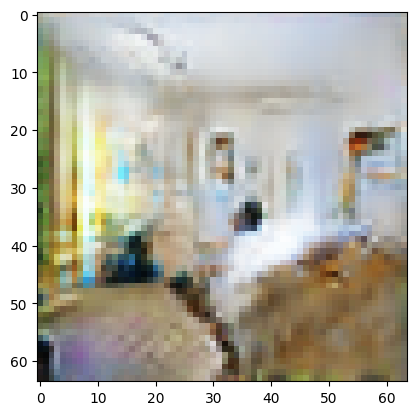

In [262]:
# display a sample noise being passed to the generator
gen.eval()
with torch.no_grad():
    # fixed_noise_test = torch.randn((BATCH_SIZE, LATENT_DIM)).to(device)
    
    img_test = gen(fixed_noise2)
    img = img_test[5
                   ]
    img = img / 2 + 0.5  # Equivalent to (img + 1) / 2
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [263]:
idx = 0  # Ensure this is correct
fixed_noises = []

# 8 steps (0 to 7) → alpha ∈ [0,1]
for i in range(16):
    alpha = i / 15
    print(f"Alpha: {alpha}")
    noise = fixed_noise1[0] * (1 - alpha) + fixed_noise2[5] * alpha
    fixed_noises.append(noise)

fixed_noises = torch.stack(fixed_noises).to(device)

# Verify endpoints
# At alpha=0, noise should equal fixed_noise1[0]
noise_alpha0 = fixed_noise1[0] * (1 - 0.0) + fixed_noise2[0] * 0.0
print(torch.allclose(noise_alpha0, fixed_noise1[0]))  # Should be True

# At alpha=1, noise should equal fixed_noise2[0]
noise_alpha1 = fixed_noise1[0] * (1 - 1.0) + fixed_noise2[0] * 1.0
print(torch.allclose(noise_alpha1, fixed_noise2[0]))  # Should be True

Alpha: 0.0
Alpha: 0.06666666666666667
Alpha: 0.13333333333333333
Alpha: 0.2
Alpha: 0.26666666666666666
Alpha: 0.3333333333333333
Alpha: 0.4
Alpha: 0.4666666666666667
Alpha: 0.5333333333333333
Alpha: 0.6
Alpha: 0.6666666666666666
Alpha: 0.7333333333333333
Alpha: 0.8
Alpha: 0.8666666666666667
Alpha: 0.9333333333333333
Alpha: 1.0
True
True


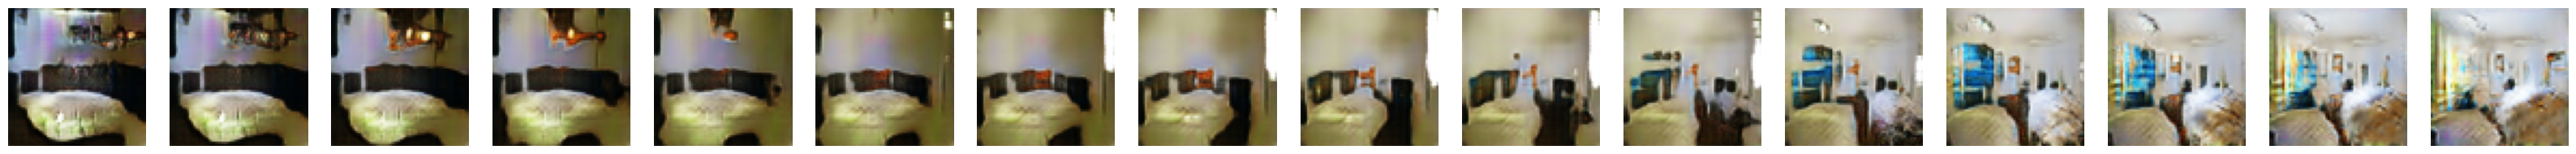

In [264]:
# display fixed noise array in a row
import numpy as np
import matplotlib.pyplot as plt

n_cols=16
gen.eval()
with torch.no_grad():
    """
    generator: Your trained generator model
    fixed_noises: List or array of fixed noise vectors
    n_cols: Number of columns in display (default is len(fixed_noises))
    """
    # Generate images from noise
    generated_images = gen(fixed_noises)
    
    # Determine layout
    n_images = len(fixed_noises)
    n_cols = n_cols or n_images
    n_rows = int(np.ceil(n_images / n_cols))
    
    # Create figure
    plt.figure(figsize=(n_cols * 2, n_rows * 2))
    
    # Display each image
    for i in range(n_images):
        plt.subplot(n_rows, n_cols, i+1)
        img = generated_images[i]
        img = (img / 2) + 0.5  # Equivalent to (img + 1) / 2
        npimg = img.cpu().numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
